# LLM (LLAMA) como clasificador de discursos de odio

Objetivos:

* Entrenar un clasificador basado en LLAMA para predicción de discursos de odio
* Diseño de prompt para ejecutar un pipeline que permita la LLM clasificar
* Evaluar los modelos de embeddings

# Librerías

In [1]:
#Incorpore las librerías en esta sección
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo de Seaborn
plt.style.use('ggplot')

# Introducción

El conjunto de datos utilizado en este estudio se construyó a partir de tweets obtenidos a través de la API de Twitter y filtrados utilizando un léxico de discurso de odio proporcionado por Hatebase.org. Inicialmente, se identificaron y recopilaron tweets que contenían términos específicos catalogados como discurso de odio por la comunidad. Este proceso resultó en una muestra de 85.4 millones de tweets, provenientes de 33,458 usuarios de Twitter.

Posteriormente, se realizó una selección aleatoria de tweets de esta muestra inicial para su análisis detallado. Estos tweets fueron evaluados manualmente por trabajadores de CrowdFlower (CF), quienes clasificaron cada tweet en una de tres categorías: discurso de odio, lenguaje ofensivo pero no discurso de odio, y ni ofensivo ni discurso de odio.

**Estructura del dataset**

Para el desarrollo de la tarea, se deben concentrar en dos columnas:

* tweet: Contiene la sentencia que debe ser evaluada.
* label: Clasificación asociada a cada sentencia de la variable tweet.

Respecto a la variable label, se tiene la siguiente codificación:

* 0 - discurso de odio
* 1 - lenguaje ofensivo
* 2 - ninguno

El conjunto de datos ya está divido en train (df_train) y test (df_test)

# 0.- Carga de datos 

In [2]:
df_train = pd.read_csv('df_train.csv')
df_test = pd.read_csv('df_test.csv')

print('Resumen del conjunto de entrenamiento:')
print(df_train.info())
print('\nResumen del conjunto de prueba:')
print(df_test.info())

Resumen del conjunto de entrenamiento:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19826 entries, 0 to 19825
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          19826 non-null  int64 
 1   count               19826 non-null  int64 
 2   hate_speech         19826 non-null  int64 
 3   offensive_language  19826 non-null  int64 
 4   neither             19826 non-null  int64 
 5   label               19826 non-null  int64 
 6   tweet               19826 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.1+ MB
None

Resumen del conjunto de prueba:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4957 entries, 0 to 4956
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          4957 non-null   int64 
 1   count               4957 non-null   int64 
 2   hate_speech         4957 non-n

In [3]:
ratio_datos = round(len(df_test)/len(df_train) * 100, 2)

print(f'El conjunto de prueba representa el {ratio_datos}% del conjunto de entrenamiento.')

El conjunto de prueba representa el 25.0% del conjunto de entrenamiento.


### Generación de objetos:

In [4]:
df_train_clean = df_train[['label', 'tweet']]
df_test_clean = df_test[['label', 'tweet']]

### Visualización del datos según tipo de discurso:

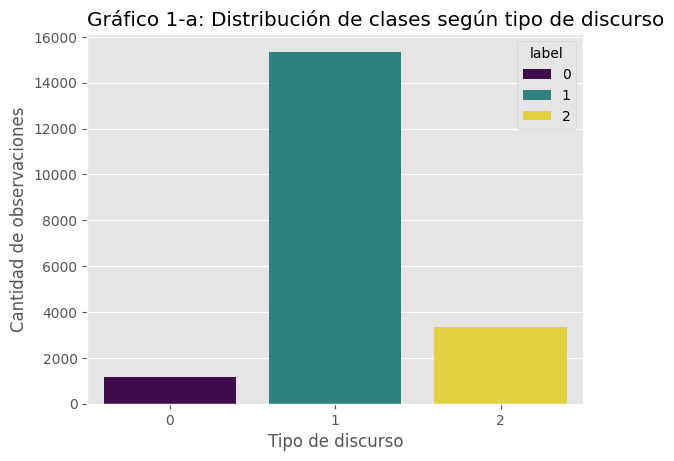

In [5]:
cantidad_registros = df_train_clean['label'].value_counts()

### Gráfico de barras :
sns.barplot(x=cantidad_registros.index, y=cantidad_registros.values, palette='viridis', hue = cantidad_registros.index)
plt.xlabel('Tipo de discurso')
plt.ylabel('Cantidad de observaciones')
plt.title('Gráfico 1-a: Distribución de clases según tipo de discurso', loc='left')
plt.show();

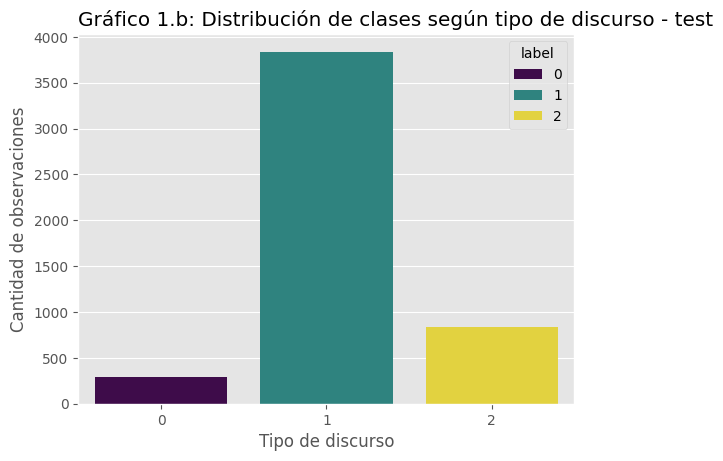

In [6]:
cantidad_registros_test = df_test_clean['label'].value_counts()

### Gráfico de barras :
sns.barplot(x=cantidad_registros_test.index, y=cantidad_registros_test.values, palette='viridis', hue = cantidad_registros_test.index)
plt.xlabel('Tipo de discurso')
plt.ylabel('Cantidad de observaciones')
plt.title('Gráfico 1.b: Distribución de clases según tipo de discurso - test', loc='left')
plt.show();

Observaciones:

 * Se observa que existe una clase mayoritaría asociada a uso de lenguaje ofensivo. Por lo tanto, para un uso de un modelo, se requerirá utilizan un modelo que pueda gestionar de manera adecuada clases minoritarias y/o utilizar métodos de re-balanceo de clases.

# 1.- Creación de embeddings

Más información en: https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

**Observación**


* Se debe utilizar GPU. Ir a "Entorno de ejecución" --> "Cambiar tipo de entorno de ejecución" --> Marcar "GPU T4".
* Se recomienda guardar los dataframes creados.

In [7]:
#EJEMPLO PARA CREAR REPRESENTACIONES DE COMENTARIOS

from sentence_transformers import SentenceTransformer
model = SentenceTransformer("all-mpnet-base-v2") 
embeddings = model.encode([ #crear representación para cada frase
    "The weather is lovely today.",
    "It's so sunny outside!",
    "He drove to the stadium.",
])
print(embeddings.shape) #ver dimensionalidad del arreglo
embeddings[0] #revisar representación comentario 1

(3, 768)


array([-5.40592819e-02, -1.71848387e-02, -3.55374105e-02,  5.00999503e-02,
        2.86727049e-03, -3.25625613e-02, -5.80761544e-02,  6.15105033e-03,
        4.56210226e-02,  1.85950883e-02, -4.00720686e-02,  8.92390758e-02,
       -2.16217227e-02, -3.36239710e-02,  1.08701969e-02, -1.05172254e-01,
        2.24103723e-02, -3.19909528e-02, -2.49627270e-02,  1.63077619e-02,
       -2.65987194e-03, -3.24465893e-02,  3.21149975e-02, -3.25165056e-02,
        5.64085133e-02, -1.06154131e-02, -1.73120964e-02,  2.34713890e-02,
        2.92384103e-02,  2.48269215e-02, -5.33476174e-02, -4.08825353e-02,
        6.37525320e-02, -4.49078567e-02,  1.85174963e-06,  1.37187270e-02,
        2.81288791e-02, -2.68435944e-03,  6.23044744e-02, -7.46229663e-02,
       -1.49293076e-02, -2.04747822e-02, -1.56179983e-02,  2.33425070e-02,
       -6.32137293e-04,  4.30108793e-02, -4.29195613e-02, -1.75441578e-02,
       -2.68617738e-02,  3.05798538e-02, -8.29362031e-03, -2.93245167e-02,
       -3.83485928e-02,  

Respuesta:

In [8]:
### Se genera función que retornará las representaciones de los comentarios, así como tipo de discurso asociado.

def generar_representaciones(df, modelo):

    """
    Esta función tiene como fin transformar los comentarios (texto) en representaciones vectoriales (embeddings), mediante un modelo de SentenceTransformer. 

    inputs:
        - df: DataFrame que contiene los comentarios y su tipo de discurso asociado.
        - modelo: modelo de SentenceTransformer que se utilizará para generar las representaciones.
    outputs:
        - df_output: DataFrame que contiene las representaciones de los comentarios y su tipo de discurso asociado.
    """
    df_output = pd.DataFrame()

    # Generar representaciones para cada comentario
    embeddings = modelo.encode(df['tweet'].tolist()
                                ,show_progress_bar=True
                                ,convert_to_numpy=True
                                ,normalize_embeddings=True)
    
    # Crear DataFrame con las representaciones
    df_output = pd.DataFrame(embeddings)
    
    # Agregar columna de tipo de discurso
    df_output['label'] = df['label'].values
    
    return df_output

In [9]:
df_train_emb = generar_representaciones(df_train_clean, model)
df_test_emb = generar_representaciones(df_test_clean, model)

Batches:   0%|          | 0/620 [00:00<?, ?it/s]

Batches:   0%|          | 0/155 [00:00<?, ?it/s]

Observaciones: 
---

* Dentro de la estrategia de encoding de los tweet, se decide configurar los embeddings con `Normalizacion`. Esto hace la norma $L_2$ sea igual a 1, evitando que normas más grandes de los tweets dominen las distancias. Dicho de otra forma, todos los embeddings tendrán la misma magnitud, solo la dirección (valor de cada parametro del tensor) será diferente, por lo tanto, sólo los diferenciará la semántica o los escrito en ellos.

* Adicionalmente, se genera un función que permita estandarizar el proceso.

#  2.- Visualización de embeddings

## 2.1 Aplicación de `PCA()`

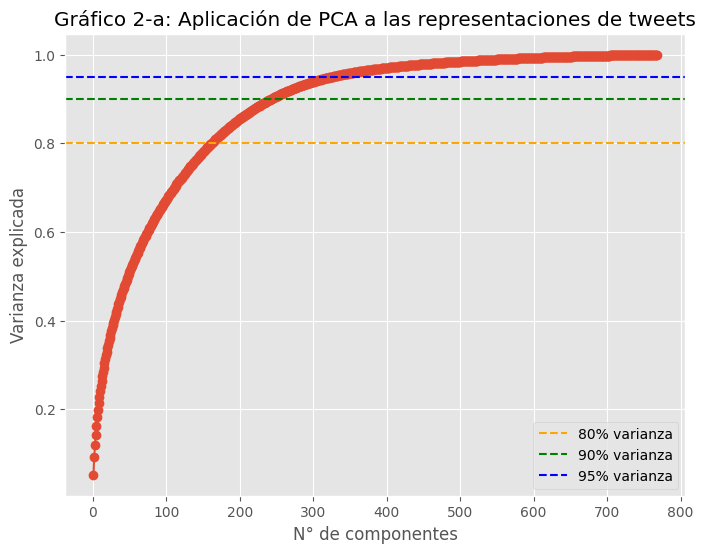

In [10]:
from sklearn.decomposition import PCA

pca_full = PCA().fit(df_train_emb.drop(columns=['label']))

# Varianza explicada acumulada
explained_var = np.cumsum(pca_full.explained_variance_ratio_)

# Graficar método del codo
plt.figure(figsize=(8,6))
plt.plot(np.arange(1, len(explained_var)+1), explained_var, marker='o')
plt.axhline(y=0.8, color='orange', linestyle='--', label="80% varianza")
plt.axhline(y=0.9, color='g', linestyle='--', label="90% varianza")
plt.axhline(y=0.95, color='b', linestyle='--', label="95% varianza")
plt.xlabel("N° de componentes")
plt.ylabel("Varianza explicada")
plt.title("Gráfico 2-a: Aplicación de PCA a las representaciones de tweets")
plt.legend()
plt.grid(True)
plt.show();

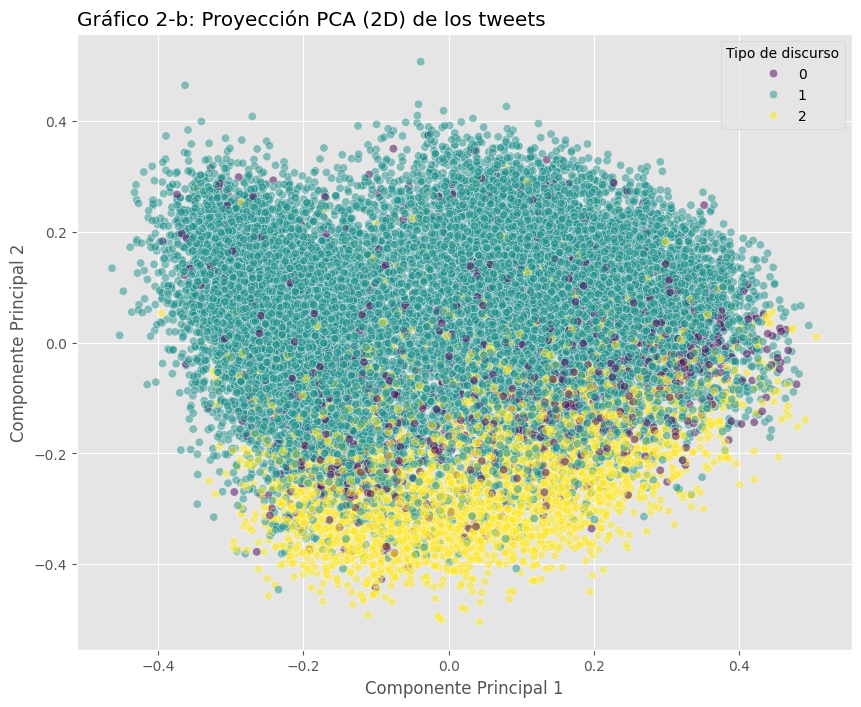

In [11]:
pca_2 = PCA(n_components=2, random_state=42)
X_train_pca_2 = pca_2.fit_transform(df_train_emb.drop(columns=['label']))
df_train_pca_2 = pd.DataFrame(X_train_pca_2, columns=['PC1', 'PC2'])
df_train_pca_2['label'] = df_train_emb['label'].values

plt.figure(figsize=(10,8))
sns.scatterplot(data=df_train_pca_2, x='PC1', y='PC2', hue='label', palette= 'viridis', alpha=0.5)
plt.title('Gráfico 2-b: Proyección PCA (2D) de los tweets', loc='left')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')    
plt.legend(title='Tipo de discurso')
plt.show();

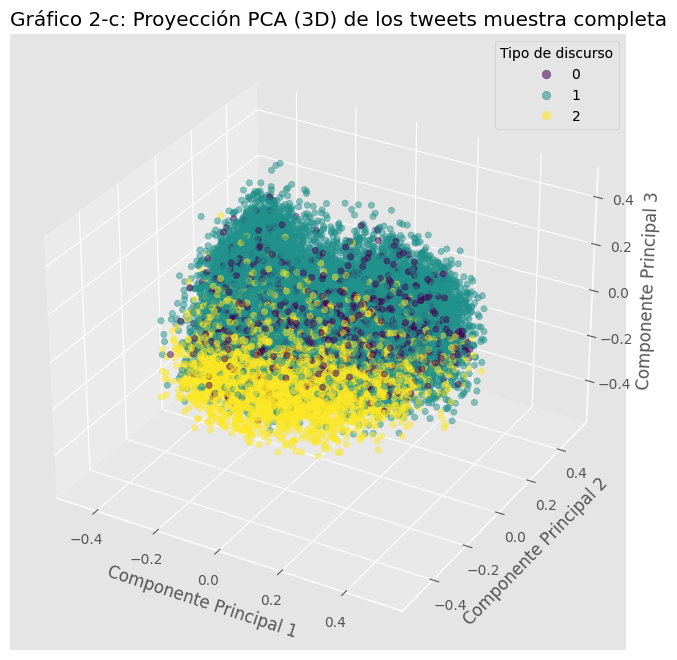

In [12]:
pca_3 = PCA(n_components=3, random_state=42)
X_train_pca_3 = pca_3.fit_transform(df_train_emb.drop(columns=['label']))
df_train_pca_3 = pd.DataFrame(X_train_pca_3, columns=['PC1', 'PC2', 'PC3'])
df_train_pca_3['label'] = df_train_emb['label'].values

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_train_pca_3['PC1'], df_train_pca_3['PC2'], df_train_pca_3['PC3'], c=df_train_pca_3['label'], cmap='viridis', alpha=0.5)
legend1 = ax.legend(*scatter.legend_elements(), title="Tipo de discurso")
ax.add_artist(legend1)
ax.set_title('Gráfico 2-c: Proyección PCA (3D) de los tweets muestra completa', loc='left')
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Componente Principal 3')
plt.show();

### 2.2 Visualización de K observaciones:



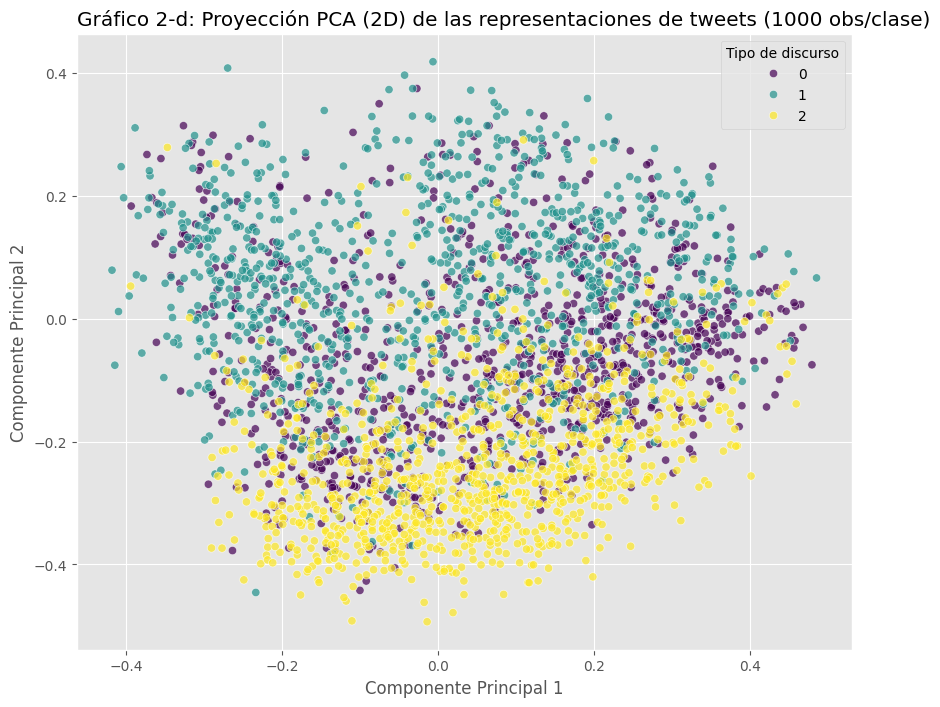

In [13]:
### Visualización 2D de 90 observaciones por clase:

k = 1000
random_state = 42

df_plot = df_train_pca_2.copy() 

df_muestra  = df_plot.groupby('label', group_keys=False).apply(lambda g: g.sample(n=min(k, len(g)),
random_state=random_state)).reset_index(drop=True)

plt.figure(figsize=(10,8))
sns.scatterplot(data=df_muestra, x='PC1', y='PC2', hue='label', palette= 'viridis', alpha=0.7)
plt.title('Gráfico 2-d: Proyección PCA (2D) de las representaciones de tweets (1000 obs/clase)', loc='left')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')    
plt.legend(title='Tipo de discurso')
plt.show();


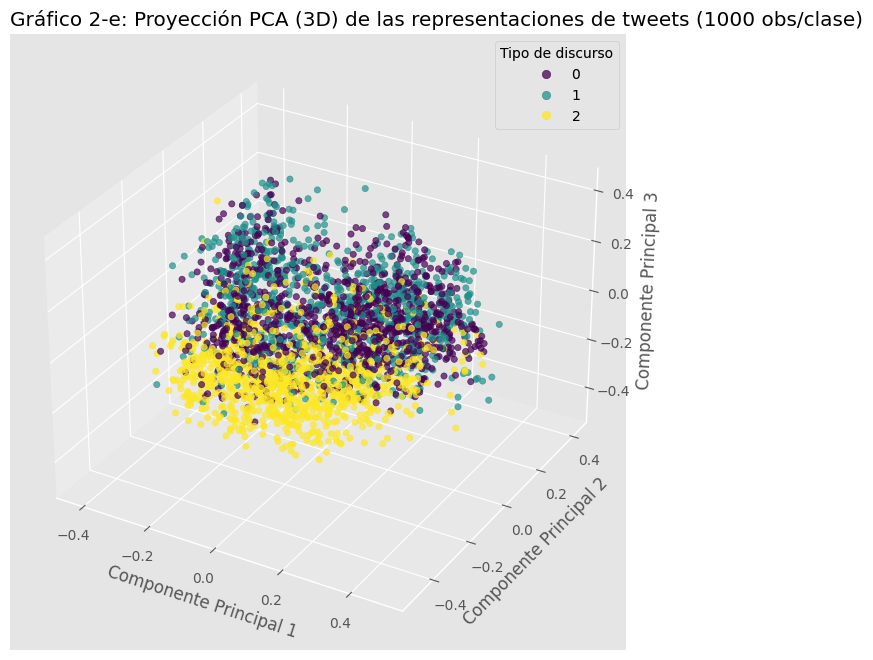

In [14]:
k = 1000
random_state = 42

df_plot_2 = df_train_pca_3.copy() 

df_muestra_2  = df_plot_2.groupby('label', group_keys=False).apply(lambda g: g.sample(n=min(k, len(g)),
random_state=random_state)).reset_index(drop=True)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_muestra_2['PC1'], df_muestra_2['PC2'], df_muestra_2['PC3'], c=df_muestra_2['label'], cmap='viridis', alpha=0.7)
legend1 = ax.legend(*scatter.legend_elements(), title="Tipo de discurso")
ax.add_artist(legend1)
ax.set_title('Gráfico 2-e: Proyección PCA (3D) de las representaciones de tweets (1000 obs/clase)', loc='left')
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Componente Principal 3')
plt.show();



Observaciones
---

* Se observa que el modelo utilizado de Sentense Transformer `all-mpnet-base-v2`, generá embeddings en alta dimensionalidad, de las cuales según la varianza explicada por PCA, entre 200 a 300 dimensiones explican el 95% de la variabilidad de los tweets (ver Gráfico 2-a). Lo anterior, es esperado ya que no toda dimensión adicional aporta información que no se encuentre capturada.

* Al observar los Gráficos 2-b y 2-c, con representaciones 2D y 3D respectivamente, vemos que existe un solapamiento de las clases 0 y 1, mientras que, se puede diferenciar la clase 2. Lo anterior, se refuerza al hacer un muestreo de $k = 1000$ observaciones, en donde, se observa que los embeddings pueden separar los comentarios neutros, de los que tienen lenguaje ofensivo y de odio.

* Si bien, 3 dimensiones no permiten separar completamente las clases, dan una intuición relevante sobre las clases 0 y 1, las que probablemente será difícil de distinguir, ya que probablemente comparten uso de vocabulario muy parecido para dar cuenta de expresiones negativas.


# 3.- Entrenar clasificador

In [15]:
### Definición de los conjuntos de datos de entrenamiento y de prueba de acuerdo a los embeddings generados anteriormente:

x_train = df_train_emb.drop(columns=['label'])
y_train = df_train_emb['label']
x_test = df_test_emb.drop(columns=['label'])
y_test = df_test_emb['label']

In [16]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix
clasificador = SGDClassifier(loss="perceptron", penalty="l2", alpha=1e-3, random_state=42, class_weight='balanced')
clasificador.fit(x_train, y_train)
clasificador.score(x_test, y_test)

0.8741174097236232

In [17]:
Y_predict = clasificador.predict(x_test)
print(classification_report(y_test, Y_predict))

              precision    recall  f1-score   support

           0       0.37      0.29      0.33       286
           1       0.92      0.93      0.92      3838
           2       0.81      0.81      0.81       833

    accuracy                           0.87      4957
   macro avg       0.70      0.68      0.69      4957
weighted avg       0.87      0.87      0.87      4957



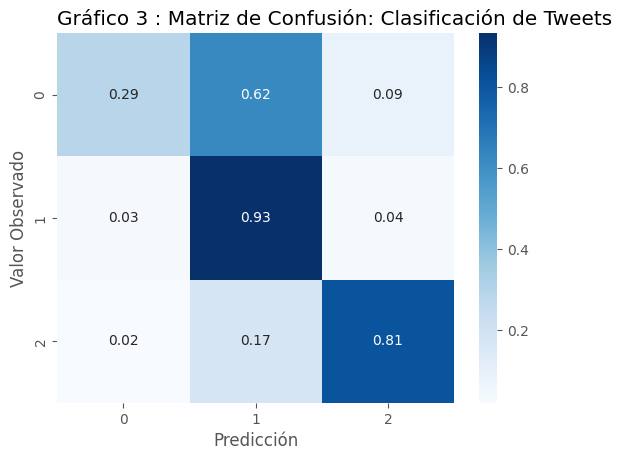

In [18]:
matriz_confusion = confusion_matrix(y_test, Y_predict)
matriz_confusion_norm = matriz_confusion.astype('float') / matriz_confusion.sum(axis=1)[:, np.newaxis]

sns.heatmap(matriz_confusion_norm, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Valor Observado')
plt.title('Gráfico 3 : Matriz de Confusión: Clasificación de Tweets', loc='left')
plt.show();

**Observaciones y Resultados:**
---

* Se observa que el modelo en el conjunto de prueba logra generalizar de buena manera los tweet's con lenguaje ofensivo. Esto se observa debido a su 93\% de aquellas que se clasificaron como dicha clase. Adicionalmente, para lo que respecta al recall, también se observa que el modelo generaliza de buena manera para esta clase.

* Para la clase 2, es decir aquellos tweet's neutros se observa que el modelo logra poder clasificar de manera adecuada a esto.

* Por contraposición, para lo que respecta a la clase 0, podemos observar que el modelo no logra generalizar de buena manera, ya que, vemos un ratio importante de falsos positivos, así como nivel bajo de racall, clasificando un gran número de estos como la clase 1. Esto va en línea con la intuición que dió la reducción de dimensionalidad, en donde, las clases 0 y 1 están intimamente relacionadas en cuanto al uso del lenguaje. Dicho de otra manera, 
esto podría darse a que los discursos de odio contienen muchas palabras que están presentes en los tweet's que pertenecen a clase de lenguaje ofensivo. Sería ideal contar con más ejemplo para que modelo pueda concluir.

* En relación con la tarea 1, se observa una mejoría con la utilización de un modelo de embbedings más robusto, sin embargo el modelo aún no puede predecir de manera adecuada para la clase 0.

# 4.- Uso de LLM como clasificador

Seleccione una muestra aleatoria de 10 ejemplos por categoría desde el conjunto de test (en total son 30 ejemplos).

Utilice el modelo ```meta-llama/Llama-3.2-3B-Instruct``` para obtener predicciones para cada comentario. Justifique el diseño del prompt.

Ver modelo en: https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct

Calcule las métricas Precision, Recall y F1-score para el conjunto analizado (general y por clase). Comente los resultados.

**Observación**

Para trabajar con el modelo ```meta-llama/Llama-3.2-3B-Instruct```, debe solicitar acceso a huggingface. Ver presentación adjunta con los pasos necesarios.

In [ ]:
#Utilizar token huggingface (Logiarse una sola vez)
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
#instanciar modelo
from transformers import pipeline
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

model_id = "meta-llama/Llama-3.2-3B-Instruct"
pipe = pipeline( 
    "text-generation",
    model=model_id,
    torch_dtype=torch.bfloat16,
    device_map=device,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cpu


In [25]:
#Ejemplo de salida
question = "Who is Geoffrey Hinton?"
messages = [{"role": "user", "content": f'''answer the following question: {question}. '''}] #Note que estamos usando f-string para facilitar la lectura de la variable question

In [26]:
outputs = pipe(messages, max_length=512)
outputs #Como se puede observar, outputs corresponde a una lista que contiene un diccionario.

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[{'generated_text': [{'role': 'user',
    'content': 'answer the following question: Who is Geoffrey Hinton?. '},
   {'role': 'assistant',
    'content': 'Geoffrey Hinton is a Canadian computer scientist and cognitive psychologist who is widely recognized as one of the pioneers of deep learning. He is known for his work on artificial neural networks, particularly in the development of the backpropagation algorithm, which is a fundamental component of modern deep learning techniques.\n\nHinton was born in 1947 in London, England, and moved to Canada in 1955. He earned his Ph.D. in computer science from the University of Cambridge in 1978. After completing his graduate studies, Hinton held research positions at several institutions, including the University of Toronto and the University of Edinburgh.\n\nIn the 1980s and 1990s, Hinton\'s work focused on developing artificial neural networks that could learn and represent complex patterns in data. He is credited with introducing the concep

In [27]:
outputs[0]["generated_text"][1]["content"]

'Geoffrey Hinton is a Canadian computer scientist and cognitive psychologist who is widely recognized as one of the pioneers of deep learning. He is known for his work on artificial neural networks, particularly in the development of the backpropagation algorithm, which is a fundamental component of modern deep learning techniques.\n\nHinton was born in 1947 in London, England, and moved to Canada in 1955. He earned his Ph.D. in computer science from the University of Cambridge in 1978. After completing his graduate studies, Hinton held research positions at several institutions, including the University of Toronto and the University of Edinburgh.\n\nIn the 1980s and 1990s, Hinton\'s work focused on developing artificial neural networks that could learn and represent complex patterns in data. He is credited with introducing the concept of "backpropagation through time" (BPTT), which is a method for training recurrent neural networks.\n\nIn the 2010s, Hinton\'s work shifted towards deve

Respuesta:

## 4.1 Selección de tweets

In [ ]:
### Elección de los 10 tweets por clase para clasificación con LLM:
df_elegidos = pd.DataFrame()
for clase in df_test_clean['label'].unique():
    df_clase = df_test_clean[df_test_clean['label'] == clase].sample(n=10, random_state=42)
    df_elegidos = pd.concat([df_elegidos, df_clase], ignore_index=True)
df_elegidos.groupby('label').size()

label
0    10
1    10
2    10
dtype: int64

In [ ]:
### Tweets seleccionados en una lista para clasificación con LLM:
text_tweets = df_elegidos['tweet'].tolist()
text_tweets

['RT @OfficiallyReid: Hoes be getting loose then move to other cities once everybody finds out they a hoe lol.',
 '@MileyCyrus I want to suck your pussy',
 'Just started my upgrade for the level 2 dark elixer drill! 1,500,000 elixer. That was a bitch to get.',
 '@littlelinnda @NasshRodriguez @linndaroose linda you just @ yourself rn you retard^^',
 "This student call me to bitch about her grade. I tell homegirl I'm seeing an assignment here as not submitted.",
 '@I_GotOne he had the hoes too',
 'My niggah',
 "RT @JamezNate: You're a bitch and nobody likes you",
 'fuck deeeez bitches',
 'RT @ShowMeATittie: LMAO bruh RT @BlazeTheGreat_: Oooooo let me find a shooting star so I could wish a bitch would http://t.co/9dqLU7dZrY',
 "RT @SkinnieTalls: It's not as easy as you'd think to find an astronaut monkey outfit at the last minute.",
 'RT @BigEl179: Luv riding the #MetroNorth with sour drunk #Yankees fans after a loss... #TooBad #MetsFan #QueensAllDay',
 '&#128553; monkey mad',
 'Just saw 

## 4.2 Elección del Prompt

Dentro del diseño del prompt se le darán 3 ejemplo por cada clase a la LLM, basándo de esta forma una estrategía de tipo `few-shot`. Se espera que la LLM clasifique de acuerdo a la clase del set de datos definido en el df_elegidos.

De esta manera, el prompt tendrá una tarea específica de clasificación de 3 clases enumeradas de 0, 1, 2, solicitandole a la LLM que entregue solo un valor. Adicionalmente se extraerán 3 para darle ejemplos claros de los tweets que deberá posteriormente clasificar. La idea de lo anterior, es que la LLM pueda resolver el mejor manera la clasificación de ciertas clases, como la 0.

In [33]:
df_prompt = pd.DataFrame()
for clase in df_test_clean['label'].unique():
    df_clase_2 = df_test_clean[df_test_clean['label'] == clase].sample(n=3, random_state=50)
    df_prompt = pd.concat([df_prompt, df_clase_2], ignore_index=True)
df_prompt

,label,tweet
0,1,"RT @FunnyPicsDepot: He really put ""side bitch ..."
1,1,"@vampirrrra k, niggah do u evem shmoke"
2,1,When I die\nThrow a couple bad bitches in my c...
3,2,"RT @Factsionary: Pink ""albino"" dolphins are ex..."
4,2,RT @inmysexdreams: I love black shoes cause I ...
5,2,Text me instead of playing flappy birds #SoIKn...
6,0,RT @MelechT: Apartheid. &#8220;@No_Cut_Card: p...
7,0,@holyh00ker he looks like a pretty dyke&#12812...
8,0,Almost got to see a white boy get beat around ...


In [56]:
def crear_prompt(tweet, df_ejemplos):
    """
    Esta función tiene como fin crear un prompt para la clasificación de un tweet, utilizando ejemplos de un DataFrame.
    inputs:
        - tweet: tweet a clasificar.
        - df_ejemplos: DataFrame que contiene ejemplos de tweets y su tipo de discurso asociado.
    outputs:
        - prompt: prompt para la clasificación del tweet.
    """
    prompt = (
        "You are an expert in classifying tweets into three categories:\n"
        "0: Hate speech\n"
        "1: Offensive language\n"
        "2: Non-hate speech\n\n"
        "Here are some examples of tweets and their corresponding categories:\n\n"
    )
    
    for _, row in df_ejemplos.iterrows():
        prompt += f"Tweet: \"{row['tweet']}\"\nCategory: {row['label']}\n\n"
    
    prompt += (
        f"Now, classify the following tweet:\nTweet: \"{tweet}\"\n"
        "Category (respond ONLY with 0, 1, or 2):"
    )
    
    return prompt

prompts = [crear_prompt(tweet, df_prompt) for tweet in text_tweets]

## 4.3 Ejecucción y Resultados

In [57]:
import re
resultados = []
for prompt in prompts:
    output = pipe(prompt, max_new_tokens=5)  
    respuesta = output[0]["generated_text"][len(prompt):].strip()
    match = re.search(r"\b[0-2]\b", respuesta)
    if match:
        resultados.append(match.group(0))
    else:
        resultados.append(respuesta)  

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

In [65]:
# Calcule las métricas Precision, Recall y F1-score para el conjunto analizado (general y por clase). Comente los resultados.
df_elegidos['predicciones'] = resultados
df_elegidos['predicciones'] = df_elegidos['predicciones'].astype(int)

print(classification_report(df_elegidos['label'], df_elegidos['predicciones']))

              precision    recall  f1-score   support

           0       0.33      0.10      0.15        10
           1       0.37      0.70      0.48        10
           2       0.88      0.70      0.78        10

    accuracy                           0.50        30
   macro avg       0.53      0.50      0.47        30
weighted avg       0.53      0.50      0.47        30



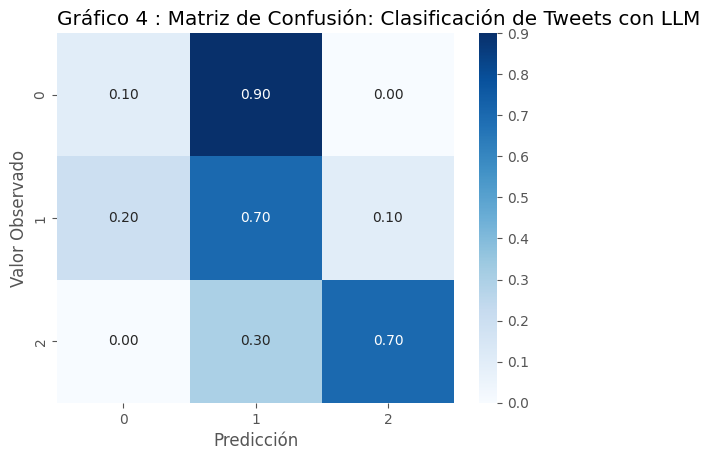

In [66]:
### Matriz de confusión:
matriz_confusion = confusion_matrix(df_elegidos['label'], df_elegidos['predicciones'])
matriz_confusion_norm = matriz_confusion.astype('float') / matriz_confusion.sum(axis=1)[:, np.newaxis]
sns.heatmap(matriz_confusion_norm, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Valor Observado')
plt.title('Gráfico 4 : Matriz de Confusión: Clasificación de Tweets con LLM', loc='left')
plt.show();

**Resultados**
----
* Se observa que la LLM no reconoce la clase 0, de hecho en la matriz de confusión se puede observar que la confunde con la clase 1.
* Si bien el modelo puede detectar la clase 1, su ajuste no es adecuado no es el mejor, ya que sólo alcanza una precisión del 37%.
* Se observa que en términos generales la mejor clase que el modelo predice es la neutra, con gran cantidad de aciertos, mostrando una precisión 88%.
* Lo anterior, muestra que mediante el uso de clases balanceadas el modelo tiene un desempeño disparejo entra las clases, no pudiendo diferenciar entre la clase 0 y 1. Sin embargo, el resultado es prometedor, pudiendo superar el azar (P = 33%)


# 5.- Conclusiones (4 puntos)

Presente sus principales conclusiones de la experimentación realizada.

Respuesta:

* Una conclusión fundamental de este trabajo es que, si bien se utilizaron Sentence Transformers para obtener representaciones semánticas, existe una clara dificultad para separar las clases 0 y 1, debido a que en términos generales comparten un lenguaje muy similar. Esta limitación se evidenció en los gráficos del apartado 2, donde los clusters muestran cierto solapamiento entre ambas categorías.

* El clasificador entrenado en el apartado 3, en términos generales muestra un buen desempeño prediciendo las clases 1 y 2. Sin embargo, no logra diferenciar de buena manera la clase 0 respecto a la 1, clasificando los discursos de odio como lenguaje ofensivo.

* Por otra parte, la LLM muestra un desempeño prometedor, sin embargo no logra clasificar de buena manera la clase 0 y 1, mostrando un mejor desempeño en la clase 2. Ahora bien, lo anterior se podría mejorar agregando una definición más certera de lo que representan estos tweets, un simple few-shot no dió el mejor desempeño.

* Se observa que es un desafío no solo técnico destinguir la diferencia entre las clases 0 y 1, porque a nivel conceptual en revisión con diferentes definiciones no hay una separación tajante objetiva. 

* Para trabajos futuros, se podría utilizar una técnica de Fine-Tuning vía LoRa para mejorar la adaptación y separación de clases para ver si el transformer puede diferenciar estos tipos de discursos.